# Create Simplified Polygons

**Index**
1. [Prepare work environment](#Prepare-work-environment)
2. [Simplify Polygons](#Simplify-Polygons)
3. [Comparison](#Comparison)

This Notebooks shows how to simplify polygons for leaner web applications using the ```arcpy``` library. The data that is used, is provided by the [Maa-amet geoportaal](https://geoportaal.maaamet.ee/eng/).

## Prepare work environment

In [2]:
import arcpy
import os
import json

Set variables

In [9]:
path = os.path.join(os.getcwd(), r'gisdata')
gdbPath = os.path.join(path, r'covid.gdb')
tmpPath = os.path.join(path, r'temp.gdb')
arcpy.env.overwriteOutput = True
arcpy.env.workspace = gdbPath

Create a temporary file database.

In [14]:
result = arcpy.CreateFileGDB_management(os.path.dirname(tmpPath) , os.path.basename(tmpPath))

In [15]:
mkrkfn = 'maakond_ruutkaart' # IN county polygon feature class

# temporary file variables
mkrk_simple = os.path.join(tmpPath, r'maakond_ruutkaart_simple')
mkrk_singleP = os.path.join(tmpPath, r'maakond_ruutkaart_singleP')
mkrk_select = os.path.join(tmpPath, r'maakond_ruutkaart_select')
# technically, it would be possible to store those "in_memory",
# but the "Shape_Area" attribute is easier accessible from within a gdb

mkrk_dissolve = 'maakond_ruutkaart_' # OUT simplified and cleaned polygon feature class

## Simplify Polygons

First step is to call the [```SimplifyPolygon```](https://pro.arcgis.com/en/pro-app/tool-reference/cartography/simplify-polygon.htm) function in the ```arcpy.cartography``` module. In this case the "POINT_REMOVE" ([Douglas-Peucker](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm)) algorithm was chosen, with a maximum point distance of 1000 meters. 

In [16]:
result = arcpy.cartography.SimplifyPolygon(mkrkfn, mkrk_simple, "POINT_REMOVE", "1000 Meters")

Since Estonia consists of many small islands, it was decided to remove the smaller islands, which are not visible from a higher zoom level, that is later used in the Dashboards. 

In [17]:
# create single polygons out of the Multipart (County-level) Polygons
result = arcpy.management.MultipartToSinglepart(mkrk_simple, mkrk_singleP)
# export polygons larger than a certain threshold (roughly size Aegna)
result = arcpy.analysis.Select(mkrk_singleP, mkrk_select, "Shape_Area > 1500000") 

Same approach here, as in the previous workflow (see [here](02a_Download_and_Analyze_Demographic_Data.ipynb#prefix_exp)). Selecting fields by prefixes to create a statistics field map. 

In [19]:
prefixes = ('F_', 'M_', 'TOT')
stat_fields = [] # here the parameter is defined that is later passed to the Dissolve function
for f in arcpy.ListFields(mkrk_select):
    if f.name.startswith(prefixes): # check if the fieldname starts with one of the predefind prefixes
        stat_fields.append([f.name ,'First']) # append the field name and desired statistics type is defined
print(stat_fields)

[['TOTAL', 'First'], ['M_TOTAL', 'First'], ['F_TOTAL', 'First'], ['TOT_LT5', 'First'], ['M_LT5', 'First'], ['F_LT5', 'First'], ['TOT_5_9', 'First'], ['M_5_9', 'First'], ['F_5_9', 'First'], ['TOT_10_14', 'First'], ['M_10_14', 'First'], ['F_10_14', 'First'], ['TOT_15_19', 'First'], ['M_15_19', 'First'], ['F_15_19', 'First'], ['TOT_20_24', 'First'], ['M_20_24', 'First'], ['F_20_24', 'First'], ['TOT_25_29', 'First'], ['M_25_29', 'First'], ['F_25_29', 'First'], ['TOT_30_34', 'First'], ['M_30_34', 'First'], ['F_30_34', 'First'], ['TOT_35_39', 'First'], ['M_35_39', 'First'], ['F_35_39', 'First'], ['TOT_40_44', 'First'], ['M_40_44', 'First'], ['F_40_44', 'First'], ['TOT_45_49', 'First'], ['M_45_49', 'First'], ['F_45_49', 'First'], ['TOT_50_54', 'First'], ['M_50_54', 'First'], ['F_50_54', 'First'], ['TOT_55_59', 'First'], ['M_55_59', 'First'], ['F_55_59', 'First'], ['TOT_60_64', 'First'], ['M_60_64', 'First'], ['F_60_64', 'First'], ['TOT_65_69', 'First'], ['M_65_69', 'First'], ['F_65_69', 'Firs

Calling the [```Dissolve```](https://pro.arcgis.com/en/pro-app/tool-reference/data-management/dissolve.htm) function to combine the single polygons (county + bigger islands) back together. <a id='county_simple'></a>

In [20]:
result = arcpy.management.Dissolve(mkrk_select, mkrk_dissolve, "MKOOD", stat_fields, "MULTI_PART", "DISSOLVE_LINES")

Remove the prefix for newly created statistics fields.

In [22]:
srString = "FIRST_" # string to search and replace
fields= [fc.name for fc in arcpy.ListFields(mkrk_dissolve, "{}*".format(srString))]
for field in fields:
    new_fn = field.replace(srString,'')
    arcpy.AlterField_management(mkrk_dissolve, field, new_fn, new_fn)

## Comparison 

Load original ('full') dataset into dictionary.

In [23]:
eeShapeCounty = {}
with arcpy.da.SearchCursor(mkrkPolyFc, ["MKOOD", "SHAPE@", "SHAPE@JSON"]) as sCursor:
    for row in sCursor:
        mkood = row[0]
        shape_arc = row[1]
        shape_json = row[2]
        eeShapeCounty[mkood] = {'full' : {'ARC' : shape_arc, 'JSON' : shape_json }}

Load simplified ('simple1') dataset into dictionary.

In [24]:
with arcpy.da.SearchCursor(mkrk_simple, ["MKOOD", "SHAPE@", "SHAPE@JSON"]) as sCursor:
    for row in sCursor:
        mkood = row[0]
        shape_arc = row[1]
        shape_json = row[2]
        eeShapeCounty[mkood]['simple1'] = {'ARC' : shape_arc, 'JSON' : shape_json }

Load cleaned final ('simple2') dataset into dictionary.

In [25]:
with arcpy.da.SearchCursor(mkrk_dissolve, ["MKOOD", "SHAPE@", "SHAPE@JSON"]) as sCursor:
    for row in sCursor:
        mkood = row[0]
        shape_arc = row[1]
        shape_json = row[2]
        eeShapeCounty[mkood]['simple2'] = {'ARC' : shape_arc, 'JSON' : shape_json }

Function to calculate the number of Vertices in a feature.

In [26]:
def calcVertices(dextr):
    vertices = []
    for ring in json.loads(dextr)['rings']:
        vertices.extend(ring)
    return len(vertices)

Loop through the simplification process and display the ArcObjects ('SHAPE@'), stored in the dictionary.

'full' has 109149 vertices, which responses to 4213.4 kilobytes.


'simple1' has 787 vertices, which responses to 30.6 kilobytes.


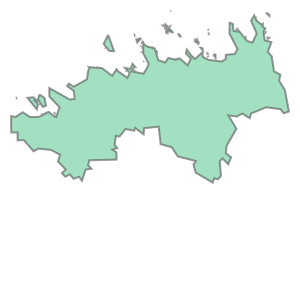

'simple2' has 180 vertices, which responses to 6.9 kilobytes.


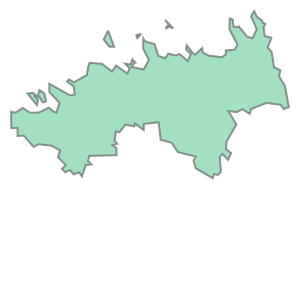

In [28]:
harju = eeShapeCounty['0037']
for key in ['full', 'simple1', 'simple2']:
    dextr = harju[key]['JSON']
    print("'{}' has {} vertices, which responses to {} kilobytes.".format(key, calcVertices(dextr), round(len(dextr.encode('utf-8'))/1024,1)))
    display(harju[key]['ARC'])